In [47]:
import matplotlib.pyplot as plt
import pandas as pd
import os

files = os.listdir('../SinCosDataset/')

print("Avaiable files:", '\n\t\t'.join(files))

data = {}
for el in files:
    data[el] = pd.read_csv(f'../SinCosDataset/{el}', sep=' ', header=None)
    data[el].columns = [f'f{i+1}' for i in range(len(data[el].columns))]

Avaiable files: datale11.txt
		data_sin.txt
		datale.txt
		datale4.txt
		datale5.txt
		data_sin1.txt
		datale7.txt
		datale6.txt
		datale2.txt
		datale3.txt
		datale1.txt
		datale33.txt
		datale22.txt


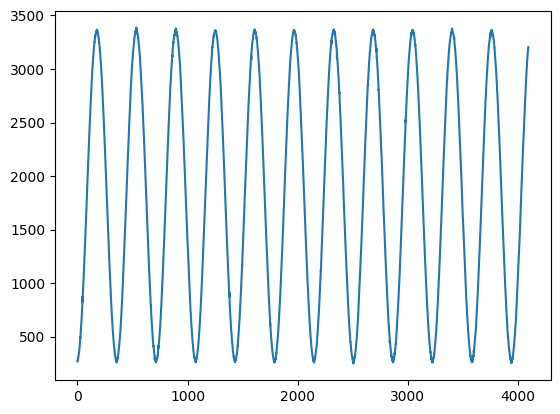

0        268
1        276
2        275
3        277
4        284
        ... 
4091    3171
4092    3171
4093    3178
4094    3199
4095    3205
Name: f2, Length: 4096, dtype: int64

In [48]:

plt.plot(data['data_sin.txt']['f2'])
plt.show()
data['data_sin.txt']['f2']

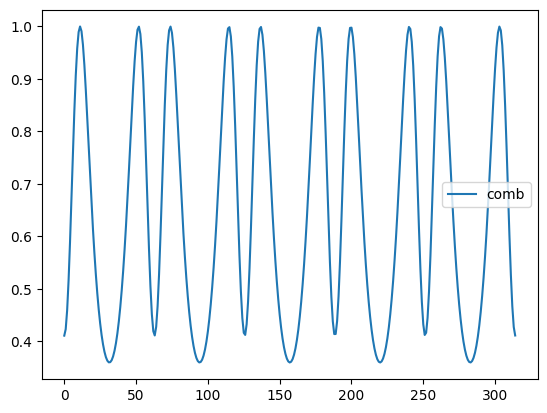

In [50]:
import numpy as np


x = np.arange(0, 10*np.pi, 0.1)
y = np.sin(x)
z = np.cos(x)
l = np.sin(np.exp(np.cos(x)))
# l2 = np.tan(np.tan(l))

data = pd.DataFrame(columns=['sin'])
data['sin'] = y
data['cos'] = z
data['comb'] = l

data.to_json('./data/SynteticSin/data.json')

plt.plot(data['comb'], label='comb')
plt.legend()
plt.show()